In [32]:
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output



In [60]:
PATCH_SIZE = 32 # 4 x 4
NUM_BASIS_FUNCS = 16

In [34]:
# Load CIFAR-10 training set without any initial transform
trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=None)

# Define the grayscale, Lanczos interpolation transform, and normalize to [0, 1]
resize_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((32, 32), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0], std=[1.0])  # Normalize to ensure values are between 0 and 1
])

# Number of images in the CIFAR-10 training set
num_images = len(trainset)

# Initialize an empty tensor to store the processed images
processed_images = torch.zeros((num_images, 32, 32))

# Loop through all images, apply transformations, and store them in the tensor
for i in range(num_images):
    image, _ = trainset[i]  # Get the image (as PIL)
    transformed_image = resize_transform(image)  # Apply grayscale, Lanczos interpolation and convert to tensor
    processed_images[i] = transformed_image.squeeze()  # Squeeze to remove the channel dimension

print(processed_images.shape)  # Should print torch.Size([50000, 32, 32])


Files already downloaded and verified
torch.Size([50000, 32, 32])


In [64]:
# Reduce the number of images from 50000 to 500
processed_images = processed_images[:10]
processed_images.shape

torch.Size([10, 32, 32])

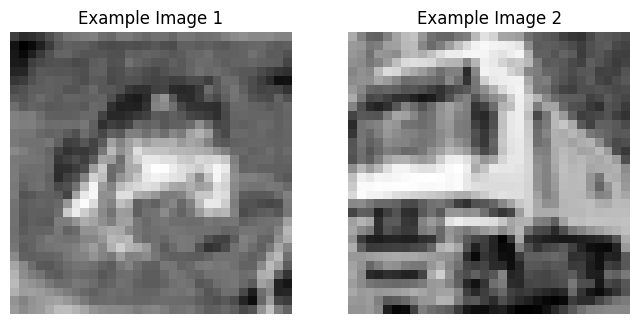

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Plot the first example image
axes[0].imshow(processed_images[0], cmap='gray')
axes[0].set_title("Example Image 1")
axes[0].axis('off')

# Plot the second example image
axes[1].imshow(processed_images[1], cmap='gray')
axes[1].set_title("Example Image 2")
axes[1].axis('off')

plt.show()


In [56]:
def Sparsity(coeffs):
    return -torch.sum(torch.abs(coeffs))

In [57]:
def PreserveInfo(basis_functions, coeffs, all_images):
    reconstructed_image = torch.sum(coeffs.view(NUM_BASIS_FUNCS, 1, 1) * basis_functions, dim=0)
    difference_images = (all_images - reconstructed_image).pow(2)
    return -torch.sum(difference_images)



In [58]:
def loss_func(basis_functions, coeffs, all_images, lamda=1):
    return -PreserveInfo(basis_functions, coeffs, all_images) - lamda * Sparsity(coeffs)
    # return -Sparsity(coeffs)


In [75]:

basis_functions = torch.rand(NUM_BASIS_FUNCS, PATCH_SIZE, PATCH_SIZE, requires_grad=True)
with torch.no_grad():
    basis_functions /= basis_functions.max()  # Normalize to make the maximum value 1

coeffs = torch.rand(NUM_BASIS_FUNCS, 1, requires_grad=True)

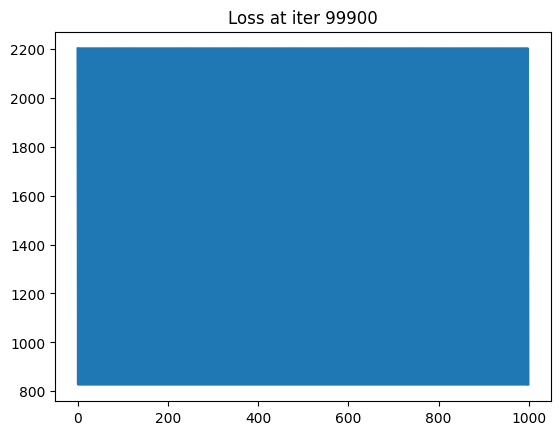

In [76]:
loss_arr = []; learning_rate = 0.1
max_grad_norm = 5.0  



for iter in range(100000):
    loss = loss_func(basis_functions, coeffs, processed_images)
    loss_arr.append(loss.item())
    loss.backward()

        # Gradient clipping
    torch.nn.utils.clip_grad_norm_(basis_functions, max_grad_norm)
    torch.nn.utils.clip_grad_norm_(coeffs, max_grad_norm)

    with torch.no_grad():
        basis_functions -= learning_rate*basis_functions.grad
        coeffs -= learning_rate*coeffs.grad
    
    if torch.isnan(basis_functions.grad).any() or torch.isinf(basis_functions.grad).any() or torch.isnan(coeffs.grad).any() or torch.isinf(coeffs.grad).any():
        print("Paused execution due to NaN or Inf in gradients. Press Enter to continue...")
        print("Basis functions gradient:", basis_functions.grad)
        print("Coefficients gradient:", coeffs.grad)
        break


    basis_functions.grad.zero_()
    coeffs.grad.zero_()


    if iter % 100 == 0:
        clear_output(wait=True)
        plt.plot(loss_arr[max(0,iter-1000):-1]); plt.title(f"Loss at iter {iter}"); plt.show()


In [77]:
loss_arr[-1]

827.9367065429688

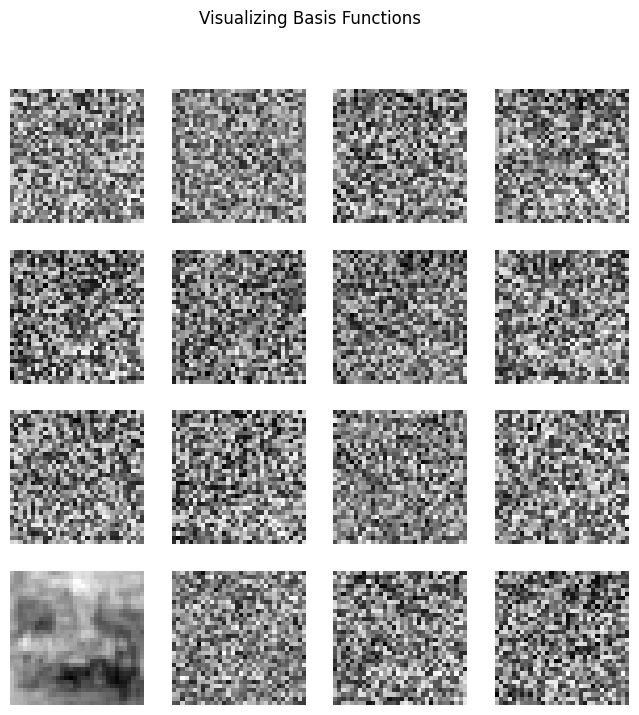

In [78]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < NUM_BASIS_FUNCS:
        ax.imshow(basis_functions[i].detach().numpy(), cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')
plt.suptitle('Visualizing Basis Functions')
plt.show()
